In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


Loaded: /kaggle/input/playground-series-s5e11/train.csv /kaggle/input/playground-series-s5e11/test.csv
Train shape: (593994, 13) Test shape: (254569, 12)


/tmp/ipykernel_13/2423292201.py:59: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if ref is not None and col in ref.columns and pd.api.types.is_categorical_dtype(ref[col]):
/tmp/ipykernel_13/2423292201.py:72: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  or pd.api.types.is_categorical_dtype(X[c]))]


Dtypes sample:
id                         int64
annual_income            float64
debt_to_income_ratio     float64
credit_score               int64
loan_amount              float64
interest_rate            float64
gender                  category
marital_status          category
education_level         category
employment_status       category
loan_purpose            category
grade_subgrade          category
dtype: object
Running XGBoost OOF...
[XGB] Fold 1/5
[0]	valid-auc:0.91033
[1]	valid-auc:0.91083
[2]	valid-auc:0.91154
[3]	valid-auc:0.91226
[4]	valid-auc:0.91244
[5]	valid-auc:0.91250
[6]	valid-auc:0.91233
[7]	valid-auc:0.91188
[8]	valid-auc:0.91323
[9]	valid-auc:0.91303
[10]	valid-auc:0.91262
[11]	valid-auc:0.91340
[12]	valid-auc:0.91352
[13]	valid-auc:0.91374
[14]	valid-auc:0.91383
[15]	valid-auc:0.91387
[16]	valid-auc:0.91389
[17]	valid-auc:0.91406
[18]	valid-auc:0.91405
[19]	valid-auc:0.91401
[20]	valid-auc:0.91416
[21]	valid-auc:0.91414
[22]	valid-auc:0.91436
[23]	valid-auc:0.9

,id,loan_paid_back
0,593994,0.942529
1,593995,0.957828
2,593996,0.625952
3,593997,0.943089
4,593998,0.952616


LightGBM mean FI:


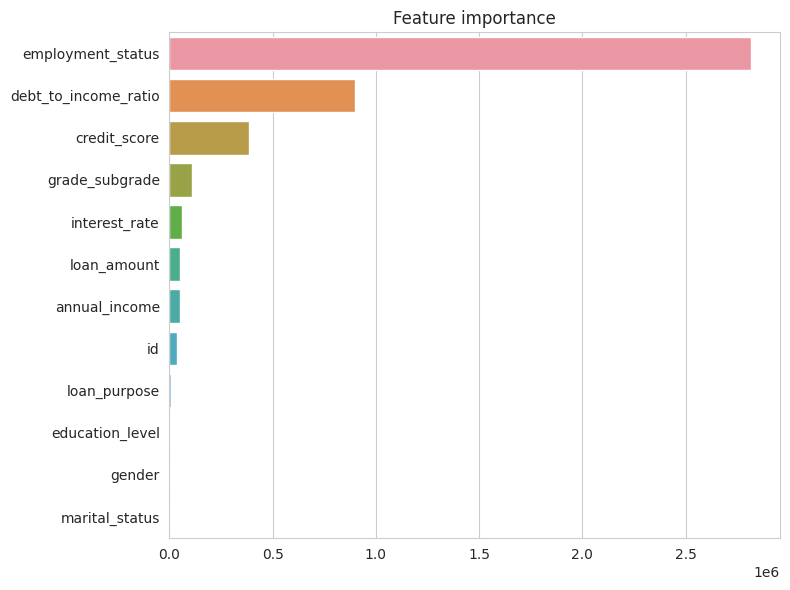

XGBoost mean FI:


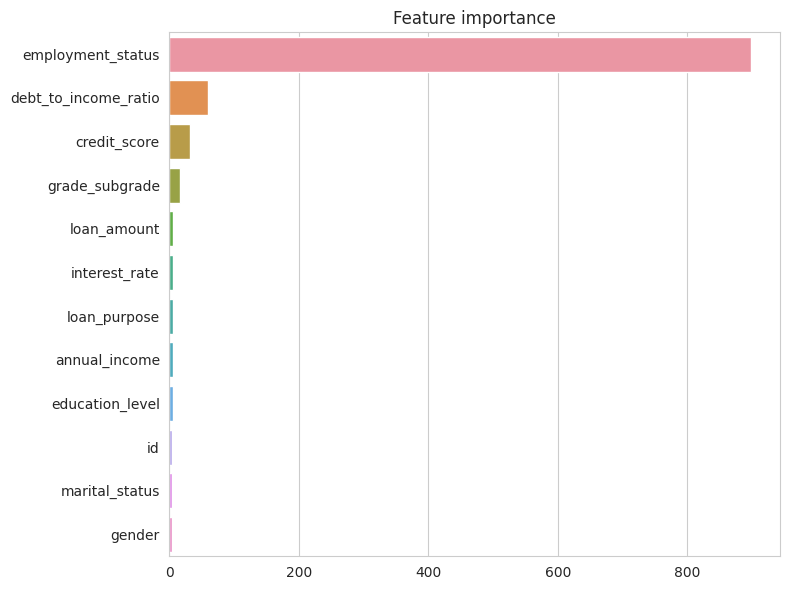

In [2]:
# Fixed pipeline cell: converts object -> category, XGBoost enable_categorical, correct OOF logic
import os, gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgb

RSEED = 42
np.random.seed(RSEED)

# ------------------ Auto-detect dataset files in /kaggle/input ------------------
base = "/kaggle/input"
folders = [f for f in os.listdir(base) if os.path.isdir(os.path.join(base, f))]
if len(folders) == 0:
    raise RuntimeError("No folders found in /kaggle/input — ensure dataset is attached.")
comp_folder = folders[0]  # pick the first competition folder
train_path = test_path = None
for root, _, files in os.walk(os.path.join(base, comp_folder)):
    for fn in files:
        low = fn.lower()
        if low.startswith("train") and low.endswith(".csv"):
            train_path = os.path.join(root, fn)
        if low.startswith("test") and low.endswith(".csv"):
            test_path = os.path.join(root, fn)

if train_path is None or test_path is None:
    raise FileNotFoundError("Couldn't find train.csv or test.csv in /kaggle/input. Files found: " + ", ".join(files))

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
print("Loaded:", train_path, test_path)
print("Train shape:", train.shape, "Test shape:", test.shape)

# ------------------ Basic feature / target split ------------------
target_col = "loan_paid_back"  # adjust if different
if target_col not in train.columns:
    raise KeyError(f"Target column '{target_col}' not found in train columns: {train.columns.tolist()[:10]}")

# Keep test ids for submission
if 'id' in test.columns:
    test_ids = test['id'].copy()
else:
    test_ids = test.index + 1

X = train.drop(columns=[target_col]).copy()
y = train[target_col].astype(int).reset_index(drop=True)   # keep pandas Series for StratifiedKFold
X_test = test.copy()

# ------------------ Convert string/object columns to categorical dtype ------------------
def convert_object_to_category(df, ref=None):
    # If ref provided, we use ref's categories when possible to keep consistency
    for col in df.columns:
        if df[col].dtype == 'object':
            # if ref has this column and is categorical, reuse categories
            if ref is not None and col in ref.columns and pd.api.types.is_categorical_dtype(ref[col]):
                df[col] = pd.Categorical(df[col], categories=ref[col].cat.categories)
            else:
                df[col] = df[col].astype('category')
    return df

# Convert both X and X_test (convert based on X to keep categories consistent where possible)
X = convert_object_to_category(X)
X_test = convert_object_to_category(X_test, ref=X)

# Sanity check: ensure all dtypes are numeric, bool, or category for XGBoost
bad_cols = [c for c in X.columns if not (pd.api.types.is_numeric_dtype(X[c]) 
                                         or pd.api.types.is_bool_dtype(X[c]) 
                                         or pd.api.types.is_categorical_dtype(X[c]))]
if bad_cols:
    print("Warning - converting remaining bad columns to category:", bad_cols)
    for c in bad_cols:
        X[c] = X[c].astype('category')
        if c in X_test.columns:
            X_test[c] = X_test[c].astype('category')

print("Dtypes sample:")
print(X.dtypes.head(15))

# ------------------ Modeling utilities ------------------
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RSEED)

def rmse_dummy(): 
    pass

# ------------------ XGBoost OOF (supports categorical via enable_categorical) ------------------
def run_xgb_oof(X_df, y_series, X_test_df, params=None, n_splits=5, num_boost_round=3000, early_stop_rounds=100):
    import gc
    from xgboost.callback import EarlyStopping

    if params is None:
        params = {
            "objective":"binary:logistic",
            "eval_metric":"auc",
            "learning_rate":0.03,
            "subsample":0.8,
            "colsample_bytree":0.7,
            "max_depth":6,
            "seed":RSEED,
            "verbosity":0,
            "enable_categorical": True
        }
    else:
        params = dict(params)
        params.setdefault("enable_categorical", True)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RSEED)
    oof = np.zeros(len(X_df))
    test_preds = np.zeros(len(X_test_df))
    fi_list = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_df, y_series)):
        print(f"[XGB] Fold {fold+1}/{n_splits}")

        X_tr = X_df.iloc[tr_idx]
        X_val = X_df.iloc[val_idx]

        # IMPORTANT: pass enable_categorical=True when creating DMatrix from pandas with category dtypes
        dtrain = xgb.DMatrix(X_tr, label=y_series.iloc[tr_idx], enable_categorical=True)
        dvalid = xgb.DMatrix(X_val, label=y_series.iloc[val_idx], enable_categorical=True)
        dtest  = xgb.DMatrix(X_test_df, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dvalid, "valid")],
            callbacks=[EarlyStopping(rounds=early_stop_rounds, save_best=True)]
        )

        best_iter = getattr(model, "best_iteration", None)
        if best_iter is None:
            best_iter = num_boost_round

        val_pred = model.predict(dvalid, iteration_range=(0, best_iter+1))
        test_pred = model.predict(dtest, iteration_range=(0, best_iter+1))

        oof[val_idx] = val_pred
        test_preds += test_pred / n_splits

        # safe feature importance mapping
        score_dict = model.get_score(importance_type='gain') or {}
        fi = pd.Series(score_dict).reindex(X_df.columns).fillna(0)
        fi_list.append(fi)

        del dtrain, dvalid, model
        gc.collect()

    cv_auc = roc_auc_score(y_series, oof)
    fi_df = pd.concat(fi_list, axis=1).fillna(0)
    return oof, test_preds, cv_auc, fi_df


   
        
# ------------------ LightGBM OOF ------------------
def run_lgb_oof(X_df, y_series, X_test_df, params=None, n_splits=5, num_boost_round=4000, early_stopping_rounds=100, log_period=200):
    if params is None:
        params = {
            'objective':'binary',
            'metric':'auc',
            'learning_rate':0.03,
            'num_leaves':31,
            'min_child_samples':20,
            'subsample':0.8,
            'colsample_bytree':0.7,
            'seed':RSEED,
            'verbosity':-1
        }
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RSEED)
    oof = np.zeros(len(X_df))
    test_preds = np.zeros(len(X_test_df))
    fi_list = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_df, y_series)):
        print(f"[LGB] Fold {fold+1}/{n_splits}")
        X_tr = X_df.iloc[tr_idx]
        X_val = X_df.iloc[val_idx]
        y_tr = y_series.iloc[tr_idx].to_numpy()
        y_val = y_series.iloc[val_idx].to_numpy()

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=num_boost_round,
            valid_sets=[dvalid],
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds),
                       lgb.log_evaluation(period=log_period)]
        )

        best_iter = getattr(model, "best_iteration", None)
        if best_iter is None:
            best_iter = num_boost_round

        val_pred = model.predict(X_val, num_iteration=best_iter)
        test_pred = model.predict(X_test_df, num_iteration=best_iter)

        oof[val_idx] = val_pred
        test_preds += test_pred / n_splits

        fi = pd.Series(model.feature_importance(importance_type='gain'), index=X_df.columns).fillna(0)
        fi_list.append(fi)

        del dtrain, dvalid, model
        gc.collect()

    cv_auc = roc_auc_score(y_series, oof)
    fi_df = pd.concat(fi_list, axis=1).fillna(0)
    return oof, test_preds, cv_auc, fi_df

# ------------------ Model parameters ------------------
xgb_params = {
    "objective":"binary:logistic",
    "eval_metric":"auc",
    "learning_rate":0.03,
    "max_depth":6,
    "subsample":0.8,
    "colsample_bytree":0.7,
    "seed":RSEED,
    "verbosity":0,
    "enable_categorical": True
}
lgb_params = {
    'objective':'binary',
    'metric':'auc',
    'learning_rate':0.03,
    'num_leaves':31,
    'subsample':0.8,
    'colsample_bytree':0.7,
    'seed':RSEED,
    'verbosity':-1
}

# ------------------ Run OOF trainings ------------------
print("Running XGBoost OOF...")
xgb_oof, xgb_test_preds, xgb_auc, xgb_fi = run_xgb_oof(X, y, X_test, xgb_params, n_splits=NFOLDS, num_boost_round=2000, early_stop_rounds=100)
print("XGBoost CV AUC:", xgb_auc)

print("Running LightGBM OOF...")
lgb_oof, lgb_test_preds, lgb_auc, lgb_fi = run_lgb_oof(X, y, X_test, lgb_params, n_splits=NFOLDS, num_boost_round=2000, early_stopping_rounds=100, log_period=200)
print("LightGBM CV AUC:", lgb_auc)

# ------------------ Stacking (Logistic Regression meta) ------------------
from sklearn.linear_model import LogisticRegression
meta_X = np.vstack([xgb_oof, lgb_oof]).T
meta_test = np.vstack([xgb_test_preds, lgb_test_preds]).T

meta_clf = LogisticRegression(max_iter=1000, random_state=RSEED)
meta_clf.fit(meta_X, y)
meta_oof = meta_clf.predict_proba(meta_X)[:,1]
meta_test_preds = meta_clf.predict_proba(meta_test)[:,1]

print("Meta CV AUC:", roc_auc_score(y, meta_oof))

# ------------------ Submission ------------------
submission = pd.DataFrame({
    "id": test_ids,
    "loan_paid_back": meta_test_preds
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv (head):")
display(submission.head())

# ------------------ Optional: show mean feature importances ------------------
def show_top_fi(fi_df, topn=15, title="Feature importance"):
    fi_mean = fi_df.mean(axis=1).sort_values(ascending=False).head(topn)
    import matplotlib.pyplot as plt, seaborn as sns
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, min(6, topn/2)))
    sns.barplot(x=fi_mean.values, y=fi_mean.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("LightGBM mean FI:")
show_top_fi(lgb_fi)
print("XGBoost mean FI:")
show_top_fi(xgb_fi)
